In [1]:
from evaluate import *

In [2]:
from PIL import Image
import numpy as np
seg = Image.open("../results/GNEMS/clouds/0002.png").convert("L")
gt = Image.open("../datasets/clouds/gt/0002.png").convert("L")
print(seg.info)
seg = np.array(seg)
gt = np.array(gt)
calculate_mIOU(seg, gt)

{'sc': '0.5674477419704009', 'vi': '0.622842737233184', 'pri': '0.19743153723047963', 'miou': '0.004448882769793272'}


0.5796328783035278

In [3]:
methods = ["DFC", "GNEMS", "DSS", "W-Net"]
# spawn threads
threads = []
all_results = {}
for method in methods:
    all_results[method] = evaluate(method, False)
with open("../results/results.json", "w") as f:
    json.dump(all_results, f, indent=4)
with open("../results/results.json", "r") as f:
    results = json.load(f)


Evaluating DFC without cache...
Evaluating DFC on clouds dataset (1/3)...
Evaluating DFC on noise dataset (2/3)...
Evaluating DFC on texture dataset (3/3)...
DFC evaluation finished
Evaluating GNEMS without cache...
Evaluating GNEMS on clouds dataset (1/3)...
Evaluating GNEMS on noise dataset (2/3)...
Evaluating GNEMS on texture dataset (3/3)...
GNEMS evaluation finished
Evaluating DSS without cache...
Evaluating DSS on clouds dataset (1/3)...
Evaluating DSS on noise dataset (2/3)...
Evaluating DSS on texture dataset (3/3)...
DSS evaluation finished
Evaluating W-Net without cache...
Evaluating W-Net on clouds dataset (1/3)...
Evaluating W-Net on noise dataset (2/3)...
Evaluating W-Net on texture dataset (3/3)...
W-Net evaluation finished
{'DFC': {'clouds': {'sc': 0.6152469298301211, 'vi': 0.45448859430209687, 'pri': 0.16266261701707868, 'miou': 0.5042742395307869}, 'noise_0.5': {'sc': 0.8791562375128072, 'vi': 0.0956705493644102, 'pri': 0.7354146216046663, 'miou': 0.8590805809944868}, 

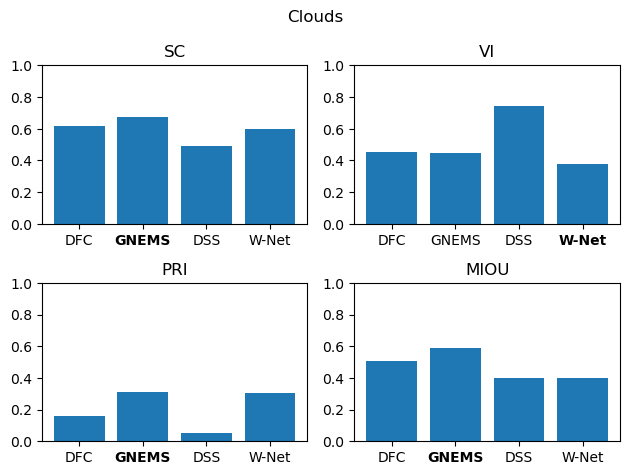

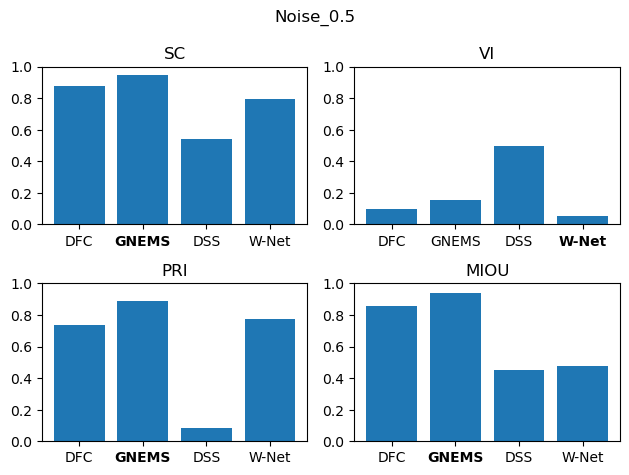

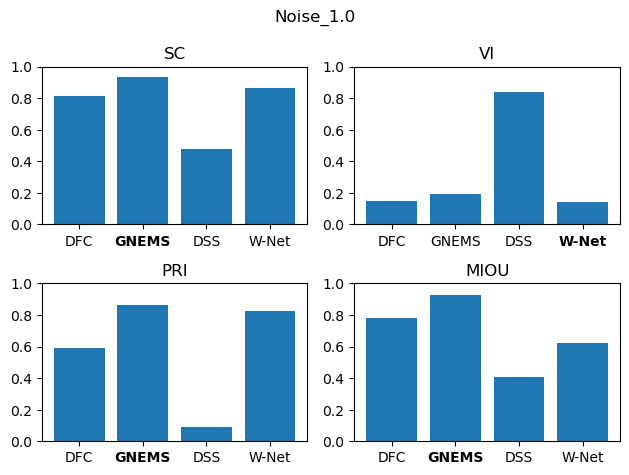

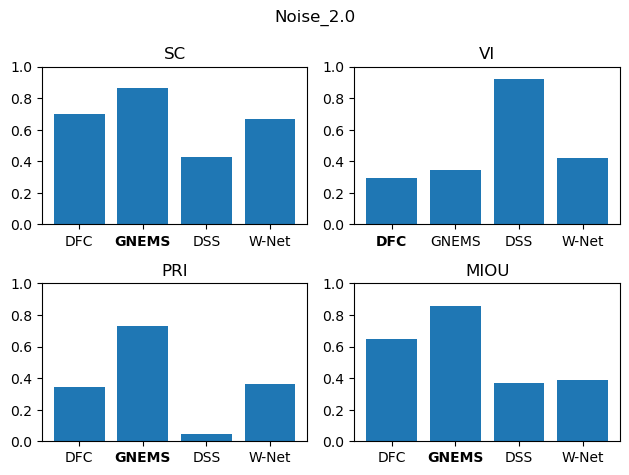

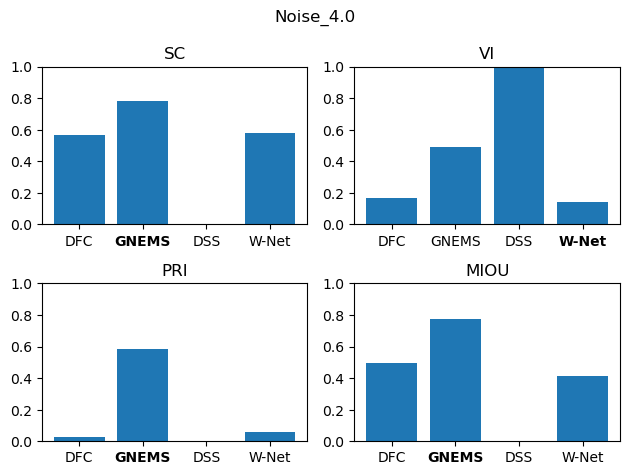

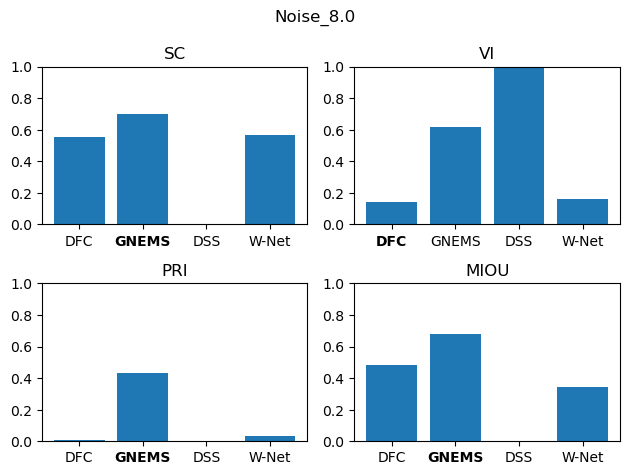

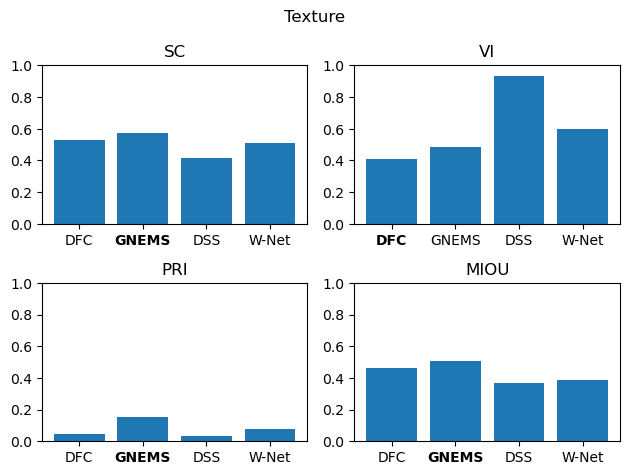

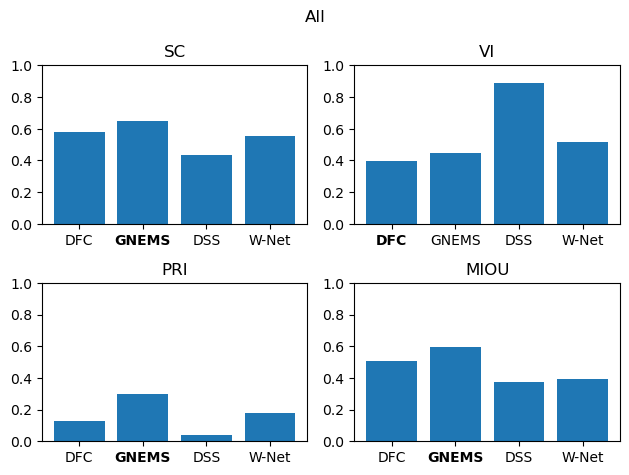

In [4]:
metrics = ["sc", "vi", "pri", "miou"]
tasks = list(results[methods[0]].keys())
for task in tasks:
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(task.capitalize())
    for i,metric in enumerate(metrics):
        values = []
        labels = []
        for method in methods:
            values.append(results[method][task][metric])
            labels.append(method)
        bolding_method = np.argmax if metric.lower() != "vi" else np.argmin
        # labels[bolding_method(values)] = "\\textbf{" + labels[bolding_method(values)] + "}"
        axs[i//2, i%2].bar(labels, values)
        axs[i//2, i%2].set_ylim(0, 1)
        axs[i//2, i%2].set_title(metric.upper())
        axs[i//2, i%2].get_xticklabels()[bolding_method(values)].set_fontweight("bold")
    plt.tight_layout()
    plt.show()
        
        

        